# Package Installation

In [1]:
!pip install propy3 scikit-learn numpy tqdm imblearn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Importing Relevant Libraries
We will be using propy's pseudoAAC for feature extraction, numpy for data processing, matplotlib for graphs (AUC-ROC), tqdm for progress bars, imblearn for handling class imbalances and sklearn for classifiers and metrics,

In [16]:
from propy.PseudoAAC import GetAPseudoAAC
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    matthews_corrcoef,
    classification_report,
    roc_curve,
)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Parsing Data
First, we need to read the data present in the .fasta files. This extracts the sequences and their appropriate labels.

In [17]:
def read_fasta(path):
    sequences = []
    labels = []
    with open(path, "r") as f:
        seq = ""
        label = None
        for line in f:
            line = line.strip()
            if line.startswith(">"):
              if seq and label is not None:
                  seq = seq.replace("X", "G")
                  seq = seq.replace("U", "G")
                  sequences.append(seq)
                  labels.append(label)
                  seq = ""
              parts = line.split("_")
              label = int(parts[-1])
            else:
                seq += line
        if seq and label is not None:
            seq = seq.replace("X", "G")
            seq = seq.replace("U", "G")
            sequences.append(seq)
            labels.append(label)
    return sequences, labels

# Filtering by length
Next, we filter the sequences for length. While this is not strictly necessary for the final phase, we used this function to test the method for smaller sequence lengths due to the heavy computational demand.

In [18]:
def filter_length(sequences, labels, min_length=None, max_length=None):
    sequences_filtered = []
    labels_filtered = []
    for seq, label in zip(sequences, labels):
        seq_length = len(seq)
        if min_length is not None and seq_length < min_length:
            continue
        if max_length is not None and seq_length > max_length:
            continue
        sequences_filtered.append(seq)
        labels_filtered.append(label)
    return sequences_filtered, labels_filtered

# Feature Extraction
Here, we perform our feature extraction using propy's GetPseudoAAC function. The lamda parameter is the additional number of pseudoAAC descriptors/ features, adding on from the usual 20. It is a non-negative integer less than the length of the input protein sequence. The weight parameter allows for us to put additional weight onto these additional descriptors/ features, and this ranges from between 0.05 to 0.7.

In [19]:
def compute_pseudoaac_features(sequences, lamda=10, weight=0.05):
    features = []
    for seq in tqdm(sequences, desc="Computing PseudoAAC features"):
        try:
            feature_dict = GetAPseudoAAC(seq, lamda=lamda, weight=weight)
            feature_values = [feature_dict[key] for key in sorted(feature_dict.keys())]
            features.append(feature_values)
        except Exception as e:
            print(f"Error computing features for sequence: {seq[:30]}... {e}")
            features.append(None)
    return features

# Filtering
We only select sequences without empty features.

In [ ]:
def filter_sequences_labels_features(sequences, labels, features):
    sequences_filtered = []
    labels_filtered = []
    features_filtered = []
    for seq, label, feat in zip(sequences, labels, features):
        if feat is not None:
            sequences_filtered.append(seq)
            labels_filtered.append(label)
            features_filtered.append(feat)
    return sequences_filtered, labels_filtered, features_filtered

# Min/max length
A minimum and maximum length is specified here, which we used to test on smaller samples of data. In our final run, we just set these bounds to include all possible sequence lengths.

In [20]:
MIN_SEQUENCE_LENGTH = 0
MAX_SEQUENCE_LENGTH = float('inf')

# Reading and processing training data
We read and process the training data and convert this information to numpy arrays.

In [21]:
# Read and process the training data
train_sequences, train_labels = read_fasta("Train.fasta")

# Filter sequences based on length
train_sequences_filtered, train_labels_filtered = filter_length(
    train_sequences, train_labels, min_length=MIN_SEQUENCE_LENGTH, max_length=MAX_SEQUENCE_LENGTH
)

# Compute PseudoAAC features for training data with progress bar
train_features = compute_pseudoaac_features(train_sequences_filtered, lamda=10, weight=0.05)

# Filter out sequences with invalid features
train_sequences_final, train_labels_final, train_features_final = filter_sequences_labels_features(
    train_sequences_filtered, train_labels_filtered, train_features
)

# Convert features and labels to NumPy arrays
X_train = np.array(train_features_final)
y_train = np.array(train_labels_final)

Computing PseudoAAC features:  97%|█████████▋| 51846/53285 [15:03:04<17:12,  1.39it/s]   

Error computing features for sequence: MARLFRASCLLSLLLAGFIPPSQGQEKSKT... 'U'


Computing PseudoAAC features: 100%|██████████| 53285/53285 [15:25:07<00:00,  1.04s/it]


# Reading and processing testing data
We read and process the testing data and convert this information to numpy arrays.

In [22]:
# Read and process the test data
test_sequences, test_labels = read_fasta("Test.fasta")

# Filter sequences based on length
test_sequences_filtered, test_labels_filtered = filter_length(
    test_sequences, test_labels, min_length=MIN_SEQUENCE_LENGTH, max_length=MAX_SEQUENCE_LENGTH
)

# Compute PseudoAAC features for test data with progress bar
test_features = compute_pseudoaac_features(test_sequences_filtered, lamda=10, weight=0.05)

# Filter out sequences with invalid features
test_sequences_final, test_labels_final, test_features_final = filter_sequences_labels_features(
    test_sequences_filtered, test_labels_filtered, test_features
)

# Convert features and labels to NumPy arrays
X_test = np.array(test_features_final)
y_test = np.array(test_labels_final)

Computing PseudoAAC features: 100%|██████████| 13452/13452 [3:53:39<00:00,  1.04s/it]  


# SMOTE for class imbalance (only on training)
As we have identified a class imbalance, we attempt to correct it using SMOTE.

In [23]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Feature Scaling
As some of the classification models require feature scaled data, we do so here. This is important for linear regression and support vector machines.

In [24]:
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Classifiers
We define a dictionary of classifiers with appropriate parameters.

In [25]:
classifiers = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
        "Naive Bayes": GaussianNB(),
        "Support Vector Machine": SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42),
        "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
        "K Nearest Neighbors": KNeighborsClassifier(),
    }

# Training classifiers, predicting and evaluating
Here, we use decide which classifiers we want to use scaled data on and which classifiers we want to use the original data on. For each of these classifiers, we calculate the relevant evaluation metrics and also save the trained models as .joblib files.


=== Random Forest ===
Starting training for Random Forest
Finished training for Random Forest
Model saved as Random_Forest_model.pkl
ROC AUC Score: 0.7609923933478667
Confusion Matrix:
[[7345 1632]
 [2050 2425]]
Matthews Correlation Coefficient: 0.3696887057857004
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      8977
           1       0.60      0.54      0.57      4475

    accuracy                           0.73     13452
   macro avg       0.69      0.68      0.68     13452
weighted avg       0.72      0.73      0.72     13452



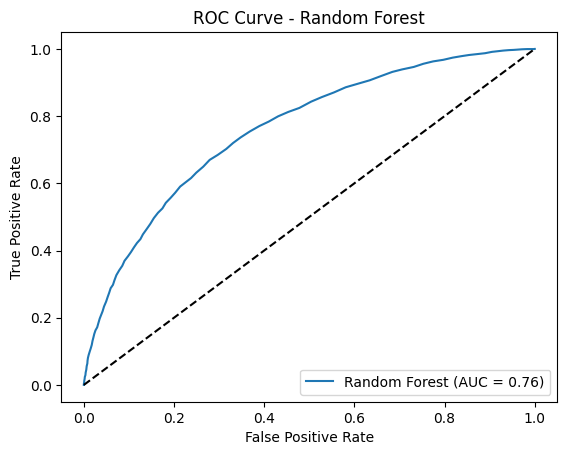


=== Logistic Regression ===
Starting training for Logistic Regression
Finished training for Logistic Regression
Model saved as Logistic_Regression_model.pkl
ROC AUC Score: 0.6989482868385564
Confusion Matrix:
[[5542 3435]
 [1441 3034]]
Matthews Correlation Coefficient: 0.27851661988035226
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.62      0.69      8977
           1       0.47      0.68      0.55      4475

    accuracy                           0.64     13452
   macro avg       0.63      0.65      0.62     13452
weighted avg       0.69      0.64      0.65     13452



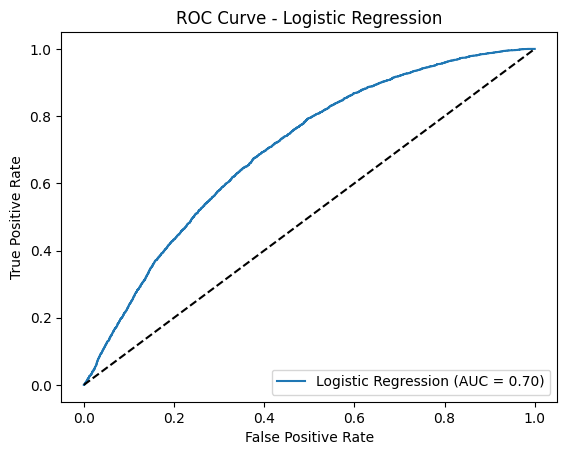


=== Naive Bayes ===
Starting training for Naive Bayes
Finished training for Naive Bayes
Model saved as Naive_Bayes_model.pkl
ROC AUC Score: 0.7284886329620762
Confusion Matrix:
[[5059 3918]
 [1083 3392]]
Matthews Correlation Coefficient: 0.3041471235958327
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.56      0.67      8977
           1       0.46      0.76      0.58      4475

    accuracy                           0.63     13452
   macro avg       0.64      0.66      0.62     13452
weighted avg       0.70      0.63      0.64     13452



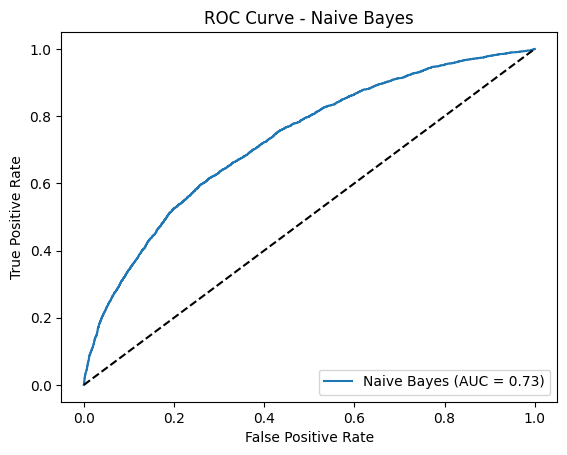


=== Support Vector Machine ===
Starting training for Support Vector Machine
Finished training for Support Vector Machine
Model saved as Support_Vector_Machine_model.pkl
ROC AUC Score: 0.778181510414884
Confusion Matrix:
[[6632 2345]
 [1447 3028]]
Matthews Correlation Coefficient: 0.3996386211220765
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      8977
           1       0.56      0.68      0.61      4475

    accuracy                           0.72     13452
   macro avg       0.69      0.71      0.70     13452
weighted avg       0.74      0.72      0.72     13452



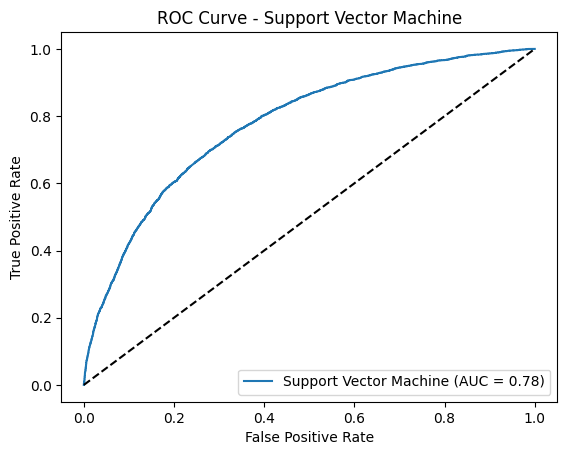


=== Decision Tree ===
Starting training for Decision Tree
Finished training for Decision Tree
Model saved as Decision_Tree_model.pkl
ROC AUC Score: 0.6046841120355371
Confusion Matrix:
[[6036 2941]
 [2072 2403]]
Matthews Correlation Coefficient: 0.20159641599743172
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.67      0.71      8977
           1       0.45      0.54      0.49      4475

    accuracy                           0.63     13452
   macro avg       0.60      0.60      0.60     13452
weighted avg       0.65      0.63      0.63     13452



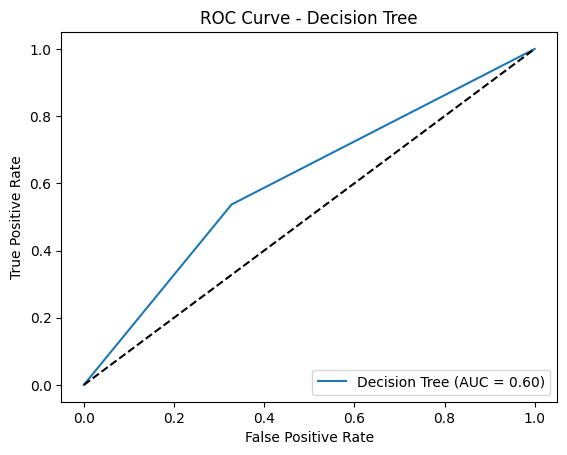


=== K Nearest Neighbors ===
Starting training for K Nearest Neighbors
Finished training for K Nearest Neighbors
Model saved as K_Nearest_Neighbors_model.pkl
ROC AUC Score: 0.7052835956320405
Confusion Matrix:
[[3643 5334]
 [ 632 3843]]
Matthews Correlation Coefficient: 0.26773814847686517
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.41      0.55      8977
           1       0.42      0.86      0.56      4475

    accuracy                           0.56     13452
   macro avg       0.64      0.63      0.56     13452
weighted avg       0.71      0.56      0.55     13452



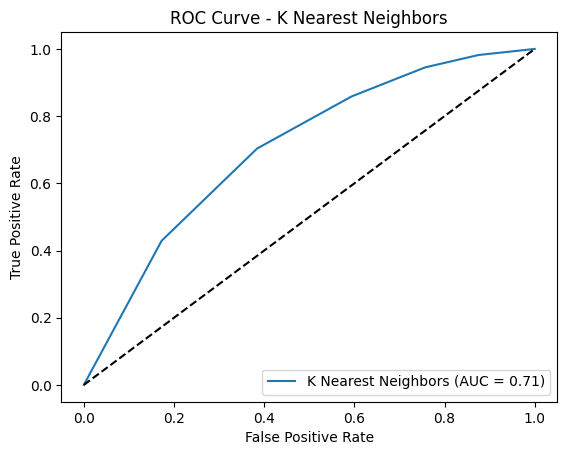

In [27]:
import joblib

scaled_classifiers = ["Logistic Regression", "Support Vector Machine", "K Nearest Neighbors"]

for name, clf in classifiers.items():
    print(f"\n=== {name} ===")
    print(f"Starting training for {name}")
    try:
        if name in scaled_classifiers:
            # Use scaled data for these classifiers
            clf.fit(X_train_res_scaled, y_train_res)
            y_pred = clf.predict(X_test_scaled)
            y_pred_prob = clf.predict_proba(X_test_scaled)[:, 1]
        else:
            # Use original data for Random Forest, Naive Bayes, and Decision Tree
            clf.fit(X_train_res, y_train_res)
            y_pred = clf.predict(X_test)
            y_pred_prob = clf.predict_proba(X_test)[:, 1]

        print(f"Finished training for {name}")

        # Save the trained model
        model_filename = f"{name.replace(' ', '_')}_model.joblib"
        joblib.dump(clf, model_filename)
        print(f"Model saved as {model_filename}")

        # Evaluate the model
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        conf_mat = confusion_matrix(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)

        print("ROC AUC Score:", roc_auc)
        print("Confusion Matrix:")
        print(conf_mat)
        print("Matthews Correlation Coefficient:", mcc)
        print("Classification Report:")
        print(report)

        # Plot ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'ROC Curve - {name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()
        plt.close()

    except Exception as e:
        print(f"An error occurred with {name}: {e}")
